In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
NOTEBOOK_DIR = Path().resolve()
BASE_DIR = NOTEBOOK_DIR.parents[0]

DATASET_DIR = BASE_DIR / "data" / "1"
TRAIN_FILE_PATH = DATASET_DIR / "mitbih_train.csv"
TEST_FILE_PATH = DATASET_DIR / "mitbih_test.csv"
ARTIFACTS_DIR = BASE_DIR / "artifacts"
print("BAse directory of this project : ",BASE_DIR)
print("Train Dataset :",TRAIN_FILE_PATH)

BAse directory of this project :  /home/srirama/sr_proj/ECGHeartbeatCategorization
Train Dataset : /home/srirama/sr_proj/ECGHeartbeatCategorization/data/1/mitbih_train.csv


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout, BatchNormalization,Input,MaxPooling1D,GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical

2025-11-26 07:52:49.165367: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load Data
train_df = pd.read_csv(TRAIN_FILE_PATH, header=None)
test_df = pd.read_csv(TEST_FILE_PATH, header=None)
train_df.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
59593,1.000000,0.890526,0.694737,0.372632,0.168421,0.128421,0.086316,0.056842,0.063158,0.042105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87389,0.705882,0.623162,0.545956,0.466912,0.393382,0.319853,0.312500,0.398897,0.420956,0.398897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
6560,1.000000,0.882096,0.659389,0.451965,0.205240,0.043668,0.000000,0.013100,0.043668,0.093886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Separate features (X) and labels (y)
X_train_raw = train_df.iloc[:, :-1].values
y_train_raw = train_df.iloc[:, -1].values
X_test_raw = test_df.iloc[:, :-1].values
y_test_raw = test_df.iloc[:, -1].values

In [6]:
# Preprocessing
NUM_CLASSES = 5 
CLASS_NAMES = ['N (0) - Normal', 'S (1) - SVEB', 'V (2) - VEB', 'F (3) - Fusion', 'Q (4) - Unknown']
INPUT_LENGTH  = X_train_raw.shape[1]
# One-Hot Encode Output Labels (Needed for categorical_crossentropy)
y_train_cat = to_categorical(y_train_raw, num_classes=NUM_CLASSES)
y_test_cat = to_categorical(y_test_raw, num_classes=NUM_CLASSES)

In [7]:
print(f"Original Training data shape: {X_train_raw.shape}")
print(f"Class distribution before balancing:\n{train_df.iloc[:, -1].value_counts(normalize=True).sort_index()}")
print(f"Number of sensor inputs : {INPUT_LENGTH} and Output Categories : {NUM_CLASSES}")

Original Training data shape: (87554, 187)
Class distribution before balancing:
187
0.0    0.827729
1.0    0.025390
2.0    0.066108
3.0    0.007321
4.0    0.073452
Name: proportion, dtype: float64
Number of sensor inputs : 187 and Output Categories : 5


In [8]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_raw),
    y=y_train_raw
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.24162492583240192), 1: np.float64(7.877103013945119), 2: np.float64(3.0253628196268143), 3: np.float64(27.317940717628705), 4: np.float64(2.7228735810915876)}


In [9]:
from sklearn.model_selection import train_test_split
# Split training data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X_train_raw, y_train_cat, test_size=0.2, random_state=42, stratify=y_train_cat) 

Because Conv1D expects:
- A sequence = 187 timesteps
- A channel per timestep = 1 feature per time instant
If you had multi-channel signals (like accelerometers with x/y/z axes), it would be (187, 3).

In [10]:
# Reshape for Conv1D: (batch, timesteps, channels)
X_train = X_train.reshape(-1, INPUT_LENGTH, 1)
X_test  = X_test.reshape(-1, INPUT_LENGTH, 1)
print(X_train.shape)   # (?, 187, 1)
print(y_train.shape)   # (?, 5)

(70043, 187, 1)
(70043, 5)


In [11]:
model_baseline = Sequential([
    Input(shape=(INPUT_LENGTH, 1)),

    Conv1D(8, kernel_size=5, activation="relu", padding="same"),
    MaxPooling1D(pool_size=2),

    Conv1D(16, kernel_size=5, activation="relu", padding="same"),
    MaxPooling1D(pool_size=2),

    Conv1D(32, kernel_size=3, activation="relu", padding="same"),
    GlobalAveragePooling1D(),

    Dense(16, activation="relu"),
    Dropout(0.3),

    Dense(NUM_CLASSES, activation="softmax")
])
model_baseline.summary()
model_baseline.compile(optimizer='adam', 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy']) 

I0000 00:00:1764143595.189666   19607 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 8)         │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 93, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 93, 16)         │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 46, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 46, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,885 (11.27 KB)

 Trainable params: 2,885 (11.27 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
]
print("--- Starting Baseline Model Training (Imbalanced Data) ---")
history_baseline = model_baseline.fit(
    X_train, y_train, 
    epochs=70, 
    batch_size=256, 
    validation_data=(X_test, y_test),
    # callbacks=callbacks,
    class_weight=class_weights
)

--- Starting Baseline Model Training (Imbalanced Data) ---
Epoch 1/70


2025-11-26 07:53:18.465977: I external/local_xla/xla/service/service.cc:163] XLA service 0x76e5a0004930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-26 07:53:18.466018: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-11-26 07:53:18.532209: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-26 07:53:18.903183: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91501


 17/274 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6249 - loss: 1.4688

I0000 00:00:1764143605.696671   19905 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.3119 - loss: 1.5179 - val_accuracy: 0.2296 - val_loss: 1.4560
Epoch 2/70
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2107 - loss: 1.4107 - val_accuracy: 0.2184 - val_loss: 1.4502
Epoch 3/70
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2333 - loss: 1.3548 - val_accuracy: 0.3212 - val_loss: 1.3960
Epoch 4/70
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3410 - loss: 1.2975 - val_accuracy: 0.5381 - val_loss: 1.1693
Epoch 5/70
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3820 - loss: 1.2027 - val_accuracy: 0.4252 - val_loss: 1.1643
Epoch 6/70
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3647 - loss: 1.1187 - val_accuracy: 0.4810 - val_loss: 1.0670
Epoch 7/70
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3840 - loss: 1.0341 - val_accuracy: 0.4749 - val_loss: 0.9992
Epoch 8/70
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3947 - loss: 0.9691 - val_accuracy: 0.3766 -

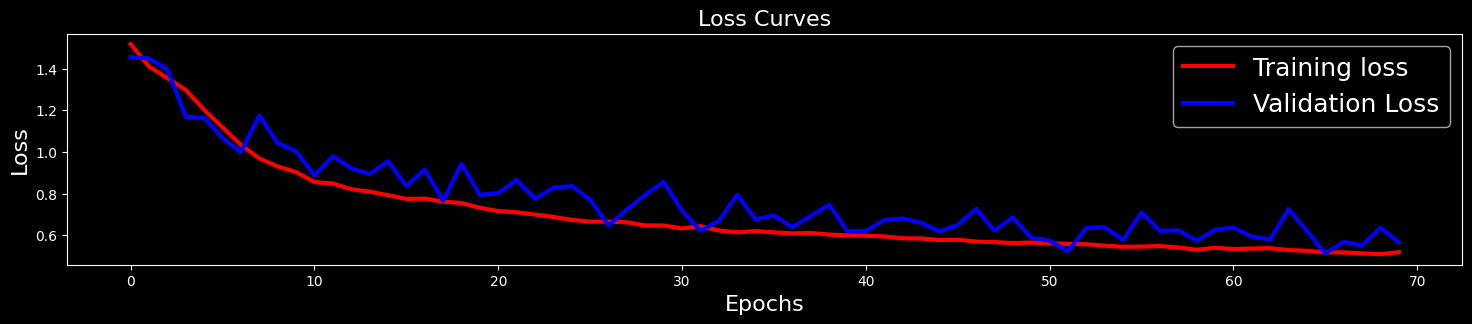

In [13]:
plt.figure(figsize=[18,3])
plt.plot(history_baseline.history['loss'], 'r', linewidth=3.0, label='Training loss')
plt.plot(history_baseline.history['val_loss'], 'b', linewidth=3.0, label='Validation Loss')
plt.legend(fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)
plt.show()

In [15]:
model_baseline.save_weights(ARTIFACTS_DIR / 'baseline_model.weights.h5') 
model_baseline.export(ARTIFACTS_DIR / "baseline_model")

INFO:tensorflow:Assets written to: /home/srirama/sr_proj/ECGHeartbeatCategorization/artifacts/baseline_model/assets


INFO:tensorflow:Assets written to: /home/srirama/sr_proj/ECGHeartbeatCategorization/artifacts/baseline_model/assets


Saved artifact at '/home/srirama/sr_proj/ECGHeartbeatCategorization/artifacts/baseline_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 187, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  130733793818192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130733793817040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130733793818960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130733793818576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130733793819728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130733793820304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130733793819920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130733757252624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130733757252240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130733757251856: TensorSpec(shap

In [18]:
# https://onnxruntime.ai/docs/tutorials/tf-get-started.html 
import tf2onnx
import onnx
import tensorflow as tf
print("Tf2onnx version :",tf2onnx.__version__)
model_baseline.output_names = ['output']
spec = [tf.TensorSpec([None, INPUT_LENGTH, 1], tf.float32, name="input")]
output_path = str(ARTIFACTS_DIR / "baseline_model.onnx")

onnx_model, _ = tf2onnx.convert.from_keras(
    model_baseline,
    input_signature=spec,
    opset=13
)
onnx.save(onnx_model , output_path)
print("Saved ONNX model to:", output_path)


I0000 00:00:1764144070.123002   19607 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1764144070.123348   19607 single_machine.cc:376] Starting new session
I0000 00:00:1764144070.125065   19607 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1764144070.164172   19607 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1764144070.169332   19607 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1764144070.169590   19607 single_machine.cc:376] Starting new session
I0000 00:00:1764144070.170344   19607 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:

Tf2onnx version : 1.16.1
Saved ONNX model to: /home/srirama/sr_proj/ECGHeartbeatCategorization/artifacts/baseline_model.onnx
